# Preprocessing

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import emoji
import seaborn as sns
from tqdm import tqdm
import nltk

## Remove empty texts

In [46]:
csv_path = '../data/reviews.csv'
df = pd.read_csv(csv_path)

# Print original row count
original_count = len(df)
print(f"Original number of rows: {original_count}")

# Remove rows where 'text' column is NaN or empty/whitespace
df.dropna(subset=['text'], inplace=True)
df = df[df['text'].str.strip().astype(bool)]

# Print cleaned row count
cleaned_count = len(df)
print(f"Remaining rows after cleaning: {cleaned_count}")
print(f"Removed {original_count - cleaned_count} rows with missing or empty text")

Original number of rows: 9073128
Remaining rows after cleaning: 2987991
Removed 6085137 rows with missing or empty text


In [47]:
original_count = len(df)
print(f"Original number of entries: {original_count}")

# Step 3: Remove rows with missing or empty 'text' or missing 'score'
df.dropna(subset=['text', 'score'], inplace=True)
df = df[df['text'].str.strip().astype(bool)]

# Step 4: Define sentiment labels based on the 'score' column
def label_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score <= 2:
        return 'negative'
    else:
        return 'neutral'

# Step 5: Apply sentiment labeling and reset index
df['sentiment'] = df['score'].apply(label_sentiment)
df.reset_index(drop=True, inplace=True)

# Step 6: Report cleaned entry count and how many were removed
cleaned_count = len(df)
print(f"Entries remaining after cleaning: {cleaned_count}")
print(f"Removed {original_count - cleaned_count} entries with missing or empty text/score.")

Original number of entries: 2987991
Entries remaining after cleaning: 2987991
Removed 0 entries with missing or empty text/score.


In [48]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df.head(10)

,beer_id,username,date,text,look,smell,taste,feel,overall,score,sentiment
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03,positive
1,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58,positive
2,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31,positive
3,125646,MFMB,2017-12-16,Pours a creamy opaque light straw yellow wi...,4.75,4.50,4.50,4.50,4.50,4.52,positive
4,125646,jngrizzaffi,2017-12-10,Pours a cloudy yellow color with a thin foa...,4.50,4.50,4.50,4.75,4.50,4.53,positive
5,125646,PDOR1960,2017-12-08,Another great brew from Treehouse!!,4.50,4.50,4.50,4.50,4.50,4.50,positive
6,125646,Lucular,2017-12-04,Pours with a cloudy yellow-orange haze with...,4.25,4.25,4.25,4.25,4.25,4.25,positive
7,205644,Brutaltruth,2017-03-29,From the tall boy can and enjoyed in a snif...,4.00,3.75,4.00,3.75,4.00,3.92,neutral
8,205644,secondtooth,2016-07-13,"Appearance: Pours a deep black, with tan he...",3.50,4.00,4.25,4.00,4.00,4.07,positive
9,150672,Derek,2016-06-07,"Beautiful, crystal clear pour with a nice h...",4.75,4.00,4.25,4.25,4.25,4.22,positive


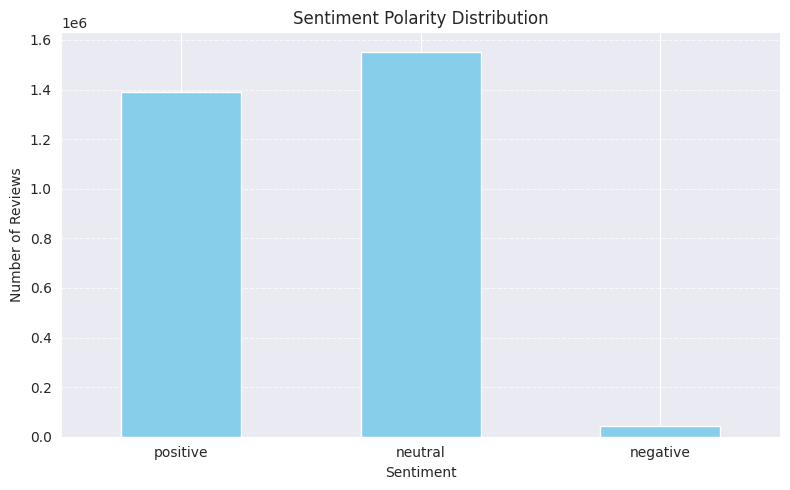

In [49]:
# Calculate the number of each sentiment label
sentiment_counts = df["sentiment"].value_counts().reindex(["positive", "neutral", "negative"], fill_value=0)

# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind="bar", color="skyblue")
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Remove emojis

In [50]:
def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')

df["text"] = df["text"].apply(remove_emoji)
df['text'] = df['text'].str.lstrip()

## Remove duplicates

In [51]:
df = df[df['text'].map(df['text'].value_counts()) == 1]
df.shape

(2893954, 11)

In [52]:
# Filter out sentences with fewer words than the average
average_word_count = df['text'].apply(lambda x: len(str(x).split())).mean()
print(f"Average number of words per sentence: {average_word_count}")
df = df[df['text'].apply(lambda x: len(str(x).split())) >= average_word_count]
df.shape

Average number of words per sentence: 114.14880747931723


(1149509, 11)

## Remove non-ABSA relevant reviews

In [53]:
# Define the aspect-specific keyword lists
aspect_keywords = {
    'look': [
        'look', 'appearance', 'color', 'colour', 'head', 'foam', 'lacing', 'clarity',
        'hazy', 'opaque', 'transparent', 'visual', 'bubble', 'carbonation', 'layer'
    ],
    'smell': [
        'smell', 'aroma', 'nose', 'scent', 'fragrance', 'odor', 'bouquet',
        'sniff', 'whiff', 'malty aroma', 'hoppy aroma'
    ],
    'taste': [
        'taste', 'flavor', 'flavour', 'aftertaste', 'bitterness', 'sweetness',
        'sourness', 'dry', 'bitter', 'sweet', 'sour', 'savory', 'malty', 'hoppy',
        'balanced', 'burnt', 'roasty', 'yeasty', 'complex'
    ],
    'feel': [
        'feel', 'mouthfeel', 'texture', 'body', 'weight', 'creaminess',
        'smoothness', 'carbonation', 'coating', 'slick', 'watery', 'full-bodied',
        'astringent', 'dryness', 'crisp', 'tingle'
    ]
}

# Convert text column to lowercase for consistent keyword matching
df['text'] = df['text'].astype(str).str.lower()

# Create a boolean column for each aspect to indicate if its keywords are mentioned
for aspect, keywords in aspect_keywords.items():
    df[f'has_{aspect}'] = df['text'].apply(
        lambda text: any(keyword in text for keyword in keywords)
    )

# Filter to retain only rows where all four aspects are present
df = df[
    df['has_look'] &
    df['has_smell'] &
    df['has_taste'] &
    df['has_feel']
].copy()

# Optional: add a column explicitly stating the presence of all aspects
df['mentioned_aspects'] = ['look, smell, taste, feel'] * len(df)

In [54]:
# Define rule: score ≥ 4 → positive, score ≤ 2 → negative, else → neutral
def score_to_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score <= 2:
        return 'negative'
    else:
        return 'neutral'

# Apply mapping to generate sentiment column
df['sentiment'] = df['score'].apply(score_to_sentiment)

Sentiment distribution before sampling:
 sentiment
neutral     459756
positive    445809
negative      9234
Name: count, dtype: int64


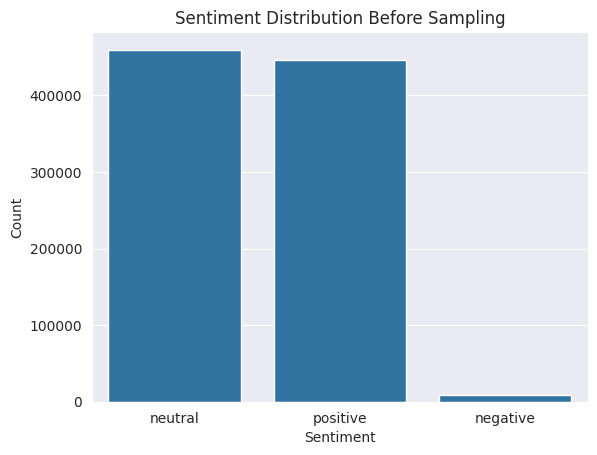

In [55]:
# Count distribution
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment distribution before sampling:\n", sentiment_counts)

# Plot
sns.countplot(data=df, x='sentiment', order=sentiment_counts.index)
plt.title('Sentiment Distribution Before Sampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [56]:
# Define desired sample size per sentiment class
n_per_class = 9234

# Perform stratified sampling by sentiment
df_sampled = df.groupby('sentiment').sample(n=n_per_class, random_state=42)

# Reset index
df_sampled.reset_index(drop=True, inplace=True)
print(f"Stratified dataset shape: {df_sampled.shape}")

Stratified dataset shape: (27702, 16)


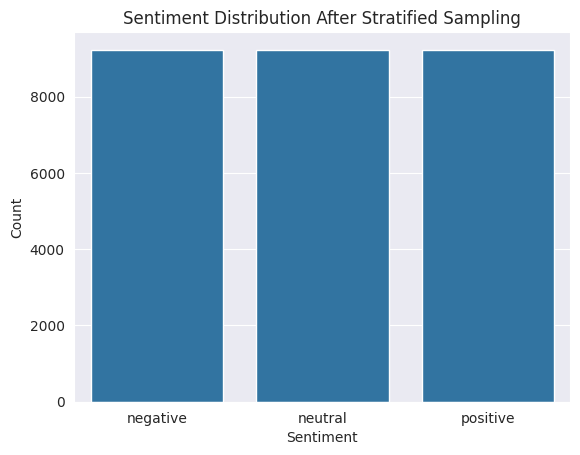

In [57]:
sns.countplot(data=df_sampled, x='sentiment')
plt.title('Sentiment Distribution After Stratified Sampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [58]:
df.to_csv('../data/reviews_with_all_4_aspects.csv', index=False)
print(f"Saved aspect-filtered dataset: {len(df)} rows → 'reviews_with_all_4_aspects.csv'")

# Save the stratified sampled dataset
df_sampled.to_csv('../data/reviews_stratified_sampled.csv', index=False)
print(f"Saved stratified sampled dataset: {len(df_sampled)} rows → 'reviews_stratified_sampled.csv'")

Saved aspect-filtered dataset: 914799 rows → 'reviews_with_all_4_aspects.csv'
Saved stratified sampled dataset: 27702 rows → 'reviews_stratified_sampled.csv'


The file "reviews_statratified_sampled.csv" contains the dataset that will be used for the baseline models. To get a first impression of the preformance.

## Text Preprocessing

In [59]:
df_sampled['text'] = df_sampled['text'].apply(lambda x: x.lower())

In [60]:
from nltk.corpus import stopwords
tqdm.pandas()

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df_sampled['text'] = df_sampled['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /home/tu2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
df_sampled

,beer_id,username,date,text,look,smell,taste,feel,overall,score,sentiment,has_look,has_smell,has_taste,has_feel,mentioned_aspects
0,1428,Aethien,2012-02-12,"poured tulip, looks nice golden yellow decent ...",3.00,1.5,1.5,2.0,2.0,1.74,negative,True,True,True,True,"look, smell, taste, feel"
1,4351,kojevergas,2011-07-31,served norrebro bryghus stemware copenhagen. r...,2.50,2.0,2.0,1.5,2.0,1.98,negative,True,True,True,True,"look, smell, taste, feel"
2,70485,CMUbrew,2012-03-10,reviewed notes 500ml poured plastic cup. a: go...,3.00,1.0,1.0,1.5,1.0,1.17,negative,True,True,True,True,"look, smell, taste, feel"
3,27069,maximum12,2010-05-12,rec'd bottle unbidden recent trade chickencoop...,2.50,2.0,2.0,2.0,1.0,1.83,negative,True,True,True,True,"look, smell, taste, feel"
4,44788,HarleyRider,2010-06-26,heading boat wife brings home six packs take o...,3.00,1.0,1.0,3.0,2.0,1.52,negative,True,True,True,True,"look, smell, taste, feel"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27697,90141,BlackBelt5112203,2013-07-26,5 oz pour tasting glass tap wicked weed taproo...,4.25,4.5,4.5,4.0,4.5,4.44,positive,True,True,True,True,"look, smell, taste, feel"
27698,2128,woodychandler,2011-08-08,afternoon aus beers continued aunt's house ain...,4.00,4.0,4.0,4.0,4.0,4.00,positive,True,True,True,True,"look, smell, taste, feel"
27699,19216,05Harley,2011-02-25,bottled on: (should bottom right hand side bot...,5.00,4.0,4.0,4.0,4.0,4.06,positive,True,True,True,True,"look, smell, taste, feel"
27700,41951,brewdlyhooked13,2008-07-19,appearance - pours dark reddish caramel thin l...,4.00,4.0,4.0,4.5,5.0,4.25,positive,True,True,True,True,"look, smell, taste, feel"
